# Burst Analysis Workflow - AI
- Input:
    * WoS_[area].csv Wos_id|Keywords|Year...
    * NSF_[area].csv ID|Year|Abstracts|Title...
- Tool: Sci2
- Output:
    * 

In [1]:
%matplotlib inline
import sys
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import pylab as plt
import math
from os import listdir
import random
import time
import matplotlib.cm as cm
from numpy.random import choice
import itertools
import operator
import itertools
from datetime import datetime as dt
import matplotlib.mlab as mlab
import re
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
from matplotlib.ticker import MaxNLocator

In [3]:
area='ai'

## Step 1 Normalize keywords in OpenRefine (see documentation)
## Step 2 Run Burst Analysis in Sci2
- input: 
    * [area]\_wos_keywords.csv
    * [area]\_nsf_keywords.csv
- get output:
    * [area]\_wos_input.csv
    * [area]\_nsf_input.csv

## Step 3 Get Burst Graph

### 1) Load data generated from Sci2

In [2]:
area='ai'

In [61]:
wos_burst_path='sci2-ai-wos-output.csv'
nsf_burst_path='sci2-ai-nsf-output.csv'
WOSkw = pd.read_csv(wos_burst_path)
NSFkw = pd.read_csv(nsf_burst_path)
NSFkw['Word'] = NSFkw['Word'].str.replace('-',' ')  # remove underscores
WOSkw['Word'] = WOSkw['Word'].str.replace('-',' ')  # remove underscores
WOSkw['Word'] = WOSkw['Word'].str.lower() 

In [87]:
### Merge two sets
WOSkw['Word'] = WOSkw['Word'].str.title() 
WOSkw['cat'] = 'wos'
NSFkw['Word'] = NSFkw['Word'].str.title() 
NSFkw['cat'] = 'nsf'
#nsfwosai15 = pd.concat([wosai15, nsfai15], ignore_index=True)
nsfwosai = pd.concat([WOSkw, NSFkw], ignore_index=True)

### Sort

In [88]:
#Top Bursts
print('nsf-',max(NSFkw.Weight),NSFkw.loc[NSFkw.Weight==max(NSFkw.Weight),'Word'].values[0])
print('wos-',max(WOSkw.Weight),WOSkw.loc[WOSkw.Weight==max(WOSkw.Weight),'Word'].values[0])

nsf- 13.04195439 Machine Learning
wos- 39.29231663 Learning (Artificial Intelligence)


### Double Bursts 

In [89]:
# WOS Double Burst
# Select all duplicate terms based on Word column
WOSkw[WOSkw.duplicated(['Word'], keep=False)]

,Word,Level,Weight,Length,Start,End,cat


In [90]:
#NSF Double Burst
NSFkw[NSFkw.duplicated(['Word'], keep=False)]

,Word,Level,Weight,Length,Start,End,cat


In [91]:
# Select all duplicate terms based on Word column
duplicates = nsfwosai[nsfwosai.duplicated(['Word'], keep=False)]
duplicates.sort_values(['Word'])

,Word,Level,Weight,Length,Start,End,cat
0,Big Data,1,16.168361,3,2015,2017,wos
19,Big Data,1,8.972520,5,2013,2017,nsf
1,Deep Learning,1,18.487784,2,2016,2017,wos
17,Deep Learning,1,7.049418,4,2014,2017,nsf
8,Machine Learning,1,26.411891,1,2017,2017,wos
13,Machine Learning,1,13.041954,3,2015,2017,nsf


### Top 10

In [92]:
wos_top={}

# sum weight and pick top15
for i in WOSkw.index:
    word=WOSkw['Word'][i].lower()
    weight=WOSkw['Weight'][i]
    start=WOSkw['Start'][i]
    end=WOSkw['End'][i]
    if word in wos_top:
        wos_top[word][0]+=weight
        if start<wos_top[word][1]:
            wos_top[word][1]=start
            wos_top[word][2]=end 
    else:
        wos_top[word]=[weight,start,end]

wos_df=pd.DataFrame.from_dict(wos_top,
                       orient='index', columns=['sum_weight', 'first_start','end'])

wos_topdf=wos_df.sort_values(ascending=[False],by=['sum_weight'])[0:10]  

for i in WOSkw.index:
    if WOSkw['Word'][i].lower() not in wos_topdf.index:
        WOSkw=WOSkw.drop([i])
WOSkw=WOSkw.reset_index(drop=True)        
WOSkw['Word']=[i.lower() for i in list(WOSkw['Word'])]

In [93]:
nsf_top={}

# sum weight and pick top15
for i in NSFkw.index:
    word=NSFkw['Word'][i].lower()
    weight=NSFkw['Weight'][i]
    start=NSFkw['Start'][i]
    end=NSFkw['End'][i]
    if word in nsf_top:
        nsf_top[word][0]+=weight
        if start<nsf_top[word][1]:
            nsf_top[word][1]=start
            nsf_top[word][2]=end        
    else:
        nsf_top[word]=[weight,start,end]

nsf_df=pd.DataFrame.from_dict(nsf_top,
                       orient='index', columns=['sum_weight', 'first_start','end'])

nsf_topdf=nsf_df.sort_values(ascending=[False],by=['sum_weight'])[0:10]  

#nsf_topdf=nsf_topdf.sort_values(ascending=[True,False],by=['first_start','sum_weight']) 

#NSFkw.loc[]

for i in NSFkw.index:
    if NSFkw['Word'][i].lower() not in nsf_topdf.index:
        NSFkw=NSFkw.drop([i])
NSFkw=NSFkw.reset_index(drop=True)     
NSFkw['Word']=[i.lower() for i in list(NSFkw['Word'])]

In [94]:
allkw_list=pd.concat([nsf_topdf,wos_topdf])
allkw_list=allkw_list.sort_values(ascending=[True,True,False],by=['first_start','end','sum_weight'])
allkw_list=allkw_list.reset_index()

#### Overlap

In [95]:
overlap=allkw_list[list(allkw_list['index'].duplicated()==True)]
allkw_list=allkw_list[list(allkw_list['index'].duplicated()!=True)] #remove duplicated
allkw_list=allkw_list.reset_index()

In [96]:
overlap_list=pd.DataFrame(columns=['Word','Length','Weight','Start','End'])
for i in range(len(overlap)):
    print(overlap['index'].values[i]+'-NSF: ')
    print(len(NSFkw.loc[NSFkw.Word==overlap['index'].values[i],]))
    print(overlap['index'].values[i]+'-WOS: ')
    print(len(WOSkw.loc[WOSkw.Word==overlap['index'].values[i],]))
    nsf_ol=NSFkw.loc[NSFkw.Word==overlap['index'].values[i],]
    wos_ol=WOSkw.loc[WOSkw.Word==overlap['index'].values[i],]
    nsf_ol=nsf_ol.reset_index()
    wos_ol=wos_ol.reset_index()
    for k in range(len(nsf_ol)):
        for j in range(len(wos_ol)):
            Word=nsf_ol.loc[k,'Word']
            Level=1
            Weight=max(nsf_ol.loc[k,'Weight'],wos_ol.loc[j,'Weight'])
            max_Start=max(nsf_ol.loc[k,'Start'],wos_ol.loc[j,'Start'])
            min_End=min(nsf_ol.loc[k,'End'],wos_ol.loc[j,'End'])
            if max_Start<=min_End: ##has overlapped year 
                overlap_list.loc[len(overlap_list),['Word','Weight','Start','End']]=[Word,Weight,max_Start,min_End]
                overlap_list.loc[len(overlap_list)-1,['Length']]=[min_End-max_Start+1]
        


big data-NSF: 
1
big data-WOS: 
1
deep learning-NSF: 
1
deep learning-WOS: 
1
machine learning-NSF: 
1
machine learning-WOS: 
1


In [97]:
overlap_list

,Word,Length,Weight,Start,End
0,big data,3,16.1684,2015,2017
1,deep learning,2,18.4878,2016,2017
2,machine learning,1,26.4119,2017,2017


In [98]:
WOSkw['Word'] = WOSkw['Word'].str.title() 
NSFkw['Word'] = NSFkw['Word'].str.title() 
overlap_list['Word'] = overlap_list['Word'].str.title()
allkw_list['index'] = allkw_list['index'].str.title()

### 2) Graph

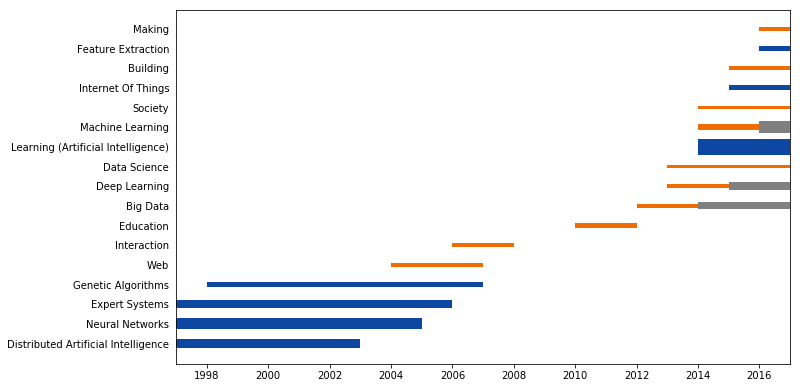

In [99]:
plt.rcParams['svg.fonttype'] = 'none'
fig = plt.figure(figsize=(11, 6.5),facecolor='white')
#end = np.array(df[['stop']])
ax1 = fig.add_subplot(111)
ax1.set_xlim((1997, 2017))

my_yticks=allkw_list['index']
y = list(range(0, len(allkw_list)))
plt.yticks(y, my_yticks)
ax1.yaxis.set_ticks_position('none')   

for x in range(0,len(WOSkw)):
    color="#0d47a1" #blue -- wos
    i=allkw_list.index[allkw_list['index']==WOSkw['Word'][x]].values[0]
    
    ax1.barh([i], width=WOSkw[x:(x+1)].Length, left=WOSkw[x:(x+1)].Start-1, color=color,height=WOSkw[x:(x+1)].Weight/max(max(WOSkw.Weight),max(NSFkw.Weight))*0.8+0.03,alpha=1)
#     ax1.barh([8], width=9, left=1997, color=color,height=0.05+0.03,alpha=1)
#     ax1.barh([8], width=9, left=1997, color=color,height=0.05+0.03,alpha=1)
  
for x in range(0,len(NSFkw)):
    color="#ef6c00" #orange -- nsf
    i=allkw_list.index[allkw_list['index']==NSFkw['Word'][x]].values[0]
    
    ax1.barh([i], width=NSFkw[x:(x+1)].Length, left=NSFkw[x:(x+1)].Start-1, color=color,height=NSFkw[x:(x+1)].Weight/max(max(WOSkw.Weight),max(NSFkw.Weight))*0.8+0.03,alpha=1)

    
for x in range(0,len(overlap_list)):
    color="grey" #grey -- nsf
    i=allkw_list.index[allkw_list['index']==overlap_list['Word'][x]].values[0]
    
    ax1.barh([i], width=overlap_list[x:(x+1)].Length, left=overlap_list[x:(x+1)].Start-1, color=color,height=overlap_list[x:(x+1)].Weight/max(max(WOSkw.Weight),max(NSFkw.Weight))*0.8+0.03,alpha=1)


    
ax1 = plt.gca()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig(area+'-burst.svg')
plt.savefig(area+'-burst.png')